In [9]:
# Libraries and utilities

import math
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image




from collections import defaultdict
from scipy.stats.stats import pearsonr

In [10]:
#Clustering utilities

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [11]:
# read dataset
df=pd.read_csv('prepared_ravdess_features.csv')

In [12]:
#CREAZIONE NUOVO DATAFRAME SENZA FEATURE CATEGORICHE
continuos_df=df.copy()
continuos_df = continuos_df.drop(columns=['emotion','vocal_channel','emotional_intensity','statement','repetition','sex'],axis = 1)


In [13]:
X = continuos_df.values
y = np.array(df['emotion'])
y_map={"neutral":0,"calm":1,"happy":2,"sad":3,"angry":4,"fearful":5,"disgust":6,"surprised":7} #utile?
y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)

## Sklearn routine
- Initialize method
- fit
- transfrom/predict

### Normalizations

In [14]:
scaler = RobustScaler() 
scaler.fit(X)
X_scal = scaler.transform(X) #Ricordarsi di denormalizzare prima delle analisi grafiche e numeriche

### Kmeans

Esperimento 0: K-means tutte le features

Test effettuato sulle features:
Index(['frame_width', 'length_ms', 'zero_crossings_sum', 'mfcc_mean',
       'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min',
       'sc_max', 'sc_kur', 'sc_skew', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'stft_skew', 'mean', 'std', 'min', 'max', 'kur', 'skew'],
      dtype='object')


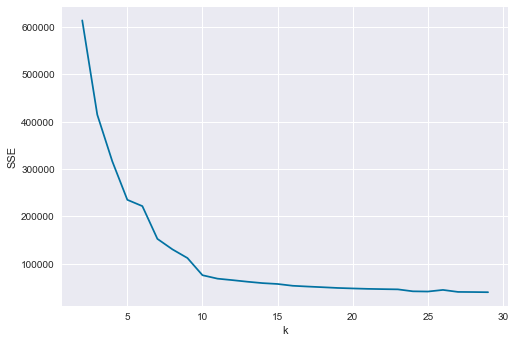

10


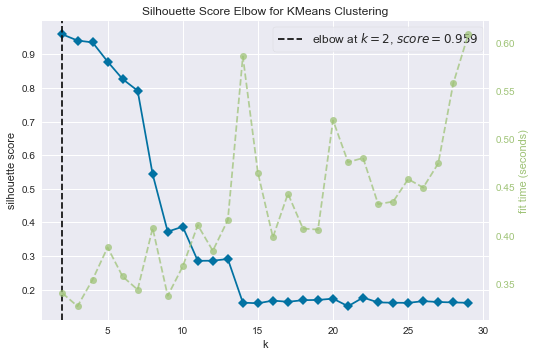

***************************************
k = 2| SSE = 613648.3459406532| silhouette = 0.9594344977984944
k = 3| SSE = 414793.1484609019| silhouette = 0.9411725369475847
k = 4| SSE = 316298.4114662821| silhouette = 0.8768834397486486
k = 5| SSE = 235139.44834603264| silhouette = 0.8353659024806043
k = 6| SSE = 221820.48540881084| silhouette = 0.33587454930365496
k = 7| SSE = 152733.84126770395| silhouette = 0.34984435638421696
k = 8| SSE = 130589.7447881763| silhouette = 0.36660482620081547
k = 9| SSE = 112267.44093106691| silhouette = 0.3790061898085012
k = 10| SSE = 76030.99132079711| silhouette = 0.38745323135746096
k = 11| SSE = 68771.32296405127| silhouette = 0.2851168655308195
k = 12| SSE = 65624.3189308974| silhouette = 0.15225054236049515
k = 13| SSE = 62278.53797367856| silhouette = 0.247813958858733
k = 14| SSE = 59363.712406709376| silhouette = 0.16407707378974323
k = 15| SSE = 57530.99638949897| silhouette = 0.1694204386331875
k = 16| SSE = 53761.66166131153| silhouette = 0.1

In [15]:
# Exp. tutte le feature ---> 
sse, silhouette, kl = res_K(df, continuos_df.columns)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [16]:
#1st K MEANS TRY
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100)#numero cluster,numero di run del k-means--> sceglierà la run che minimizza SSE,max numero iterazioni per ogni run
kmeans.fit(X_scal)
np.unique(kmeans.labels_, return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6]),
 array([2345,    1,   25,    1,   37,    4,    4], dtype=int64))

In [17]:
#Da diversi esperimenti si può notare che con tutte le features utilizzate per gli esperimenti si realizzano clustars BAD-SEPARATED
# ---> quindi l'idea è di suddividere il dataset in 4 sottoinsiemi ed effettuare esperimenti di clustering su ogni subset per determinare il migliore
# in termini di trade off(SSE,Silhouette) e well-separatedly a parità di K scelto. 

kmeans = KMeans(n_clusters=9, n_init=10, max_iter=100)#numero cluster,numero di run del k-means--> sceglierà la run che minimizza SSE,max numero iterazioni per ogni run
kmeans.fit(X_scal)
np.unique(kmeans.labels_, return_counts=True) 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([2208,    1,    1,    4,   20,   19,    4,   91,   69], dtype=int64))

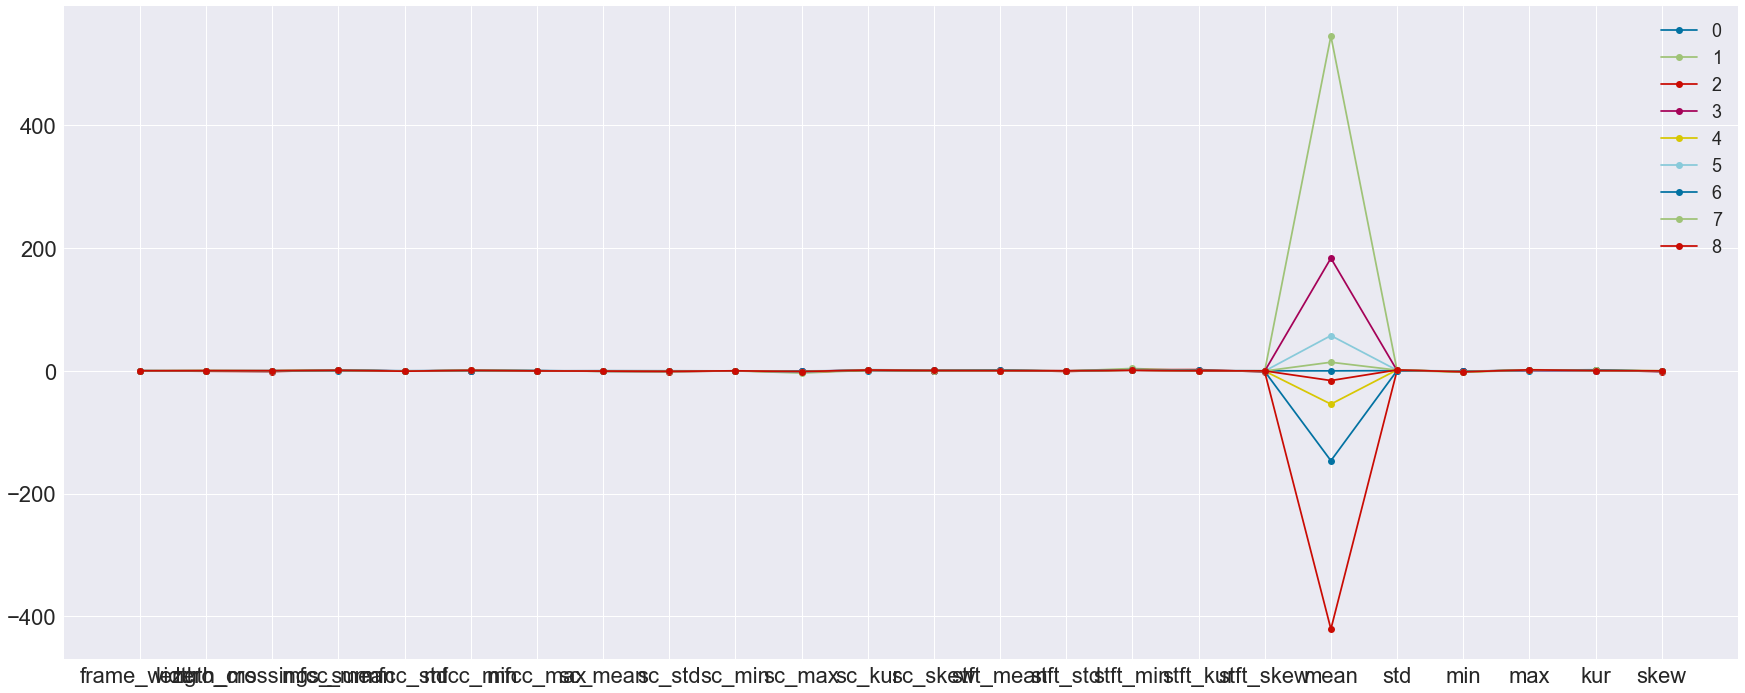

In [18]:
# Parallel plot per K-means con k=9 per tutte le features

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(continuos_df.columns)), continuos_df.columns, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()




Creazione 4 subset

In [19]:
original_audio=['length_ms','mean','frame_width','zero_crossings_sum','std','min', 'max','kur','skew']
original_audio2=['length_ms','zero_crossings_sum','std','min', 'max','kur','skew']
mfcc_audio=['mfcc_mean','mfcc_std','mfcc_min','mfcc_max']
sc_audio=['sc_mean','sc_std','sc_min','sc_max','sc_kur','sc_skew']
stft_audio=['stft_mean','stft_std', 'stft_min','stft_kur', 'stft_skew']


Testiamo il K-means nell'intervallo(2,30) per ogni sottoinsieme definito

In [20]:
# Funzione per visualizzare SSE,Silhouette per tot istanze del K means
# utilizza il KneeLockator per identificare l ipotetico miglior K su cui va fatto tradeoff

#!pip install yellowbrick
#!pip install kneed
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

def res_K(df, features):
    print("Test effettuato sulle features:")
    print(features)
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(df[features])
    sse = {}
    silhouette = {}
    for k in range(2, 30):
        kmeans = KMeans( init="random", n_clusters=k, max_iter=1000).fit(scaled_features)
        #L'inertia è la somma delle distanza degli esempio rispetto al centro del cluster più vicino
        sse[k] = kmeans.inertia_
        silhouette[k] = silhouette_score(scaled_features, kmeans.labels_)
        
    plt.figure()
    plt.style.use('seaborn-darkgrid')
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.show()
    kl = KneeLocator(
        range(2, 30), list(sse.values()), curve="convex", direction="decreasing"
    )
    
    print(kl.elbow)
    
    model = KMeans()
    visualizer = KElbowVisualizer(
            model, k=(2,30), metric='silhouette',locate_elbow=True
    )

    visualizer.fit(scaled_features)        # Fit the data to the visualizer
    visualizer.show()
    

    print("***************************************")
    
    return sse, silhouette, kl.elbow

Esperimento 1: original_audio

Test effettuato sulle features:
['length_ms', 'mean', 'frame_width', 'zero_crossings_sum', 'std', 'min', 'max', 'kur', 'skew']


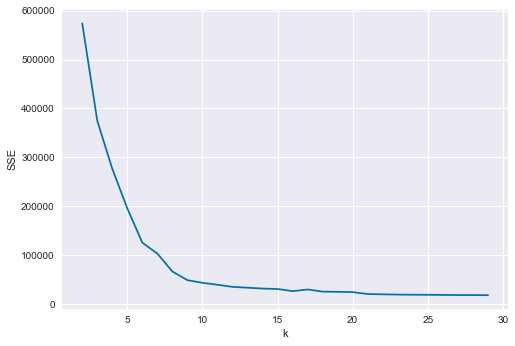

8


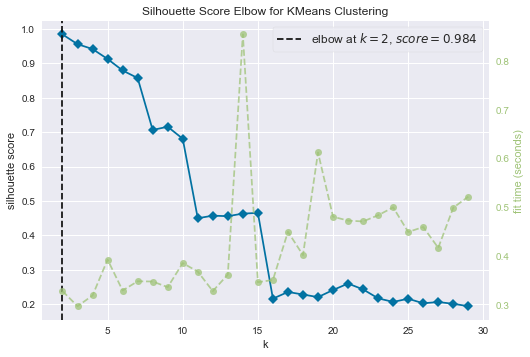

***************************************
k = 2| SSE = 573721.9368403171| silhouette = 0.969236617272592
k = 3| SSE = 374914.33412695484| silhouette = 0.956048966863395
k = 4| SSE = 276640.41411119915| silhouette = 0.9115553987324996
k = 5| SSE = 195666.0776836143| silhouette = 0.8854899428361745
k = 6| SSE = 125776.3681536261| silhouette = 0.8495089185463989
k = 7| SSE = 103583.29726188496| silhouette = 0.7833176617624932
k = 8| SSE = 66915.12183264169| silhouette = 0.734874453238107
k = 9| SSE = 49287.27973561936| silhouette = 0.6879305933949954
k = 10| SSE = 43883.25994243986| silhouette = 0.43720354426892977
k = 11| SSE = 39883.829957813796| silhouette = 0.4576851780978492
k = 12| SSE = 35619.870152667114| silhouette = 0.47534909472505654
k = 13| SSE = 33845.465086003656| silhouette = 0.21405044382523958
k = 14| SSE = 32150.693641931823| silhouette = 0.2416260736022729
k = 15| SSE = 31235.253435342438| silhouette = 0.2178639442497992
k = 16| SSE = 26864.76743191925| silhouette = 0.21

In [21]:
# Exp. original_audio ---> k=9 miglior tradeoff

sse, silhouette, kl = res_K(df, original_audio)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [22]:
# Come si evince dai dati il K-means con questo sottoinsieme è buono in termini di tradeoff(SSE,Silhouette) ma fa schifo in termini di well-separatedly
# k=9 migliore ---> in termini di SSE,Silhouette(SSE=49287,Silhouette= 0.688) è ottimo ma fa schifo in termini di well-separatedly
X1=continuos_df[original_audio]
scaler = RobustScaler() 
scaler.fit(X1)
X1_scal = scaler.transform(X1)

kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10, max_iter=100)
kmeans.fit(X1_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([2192,    1,    3,   21,    4,   19,    1,  110,   66], dtype=int64))

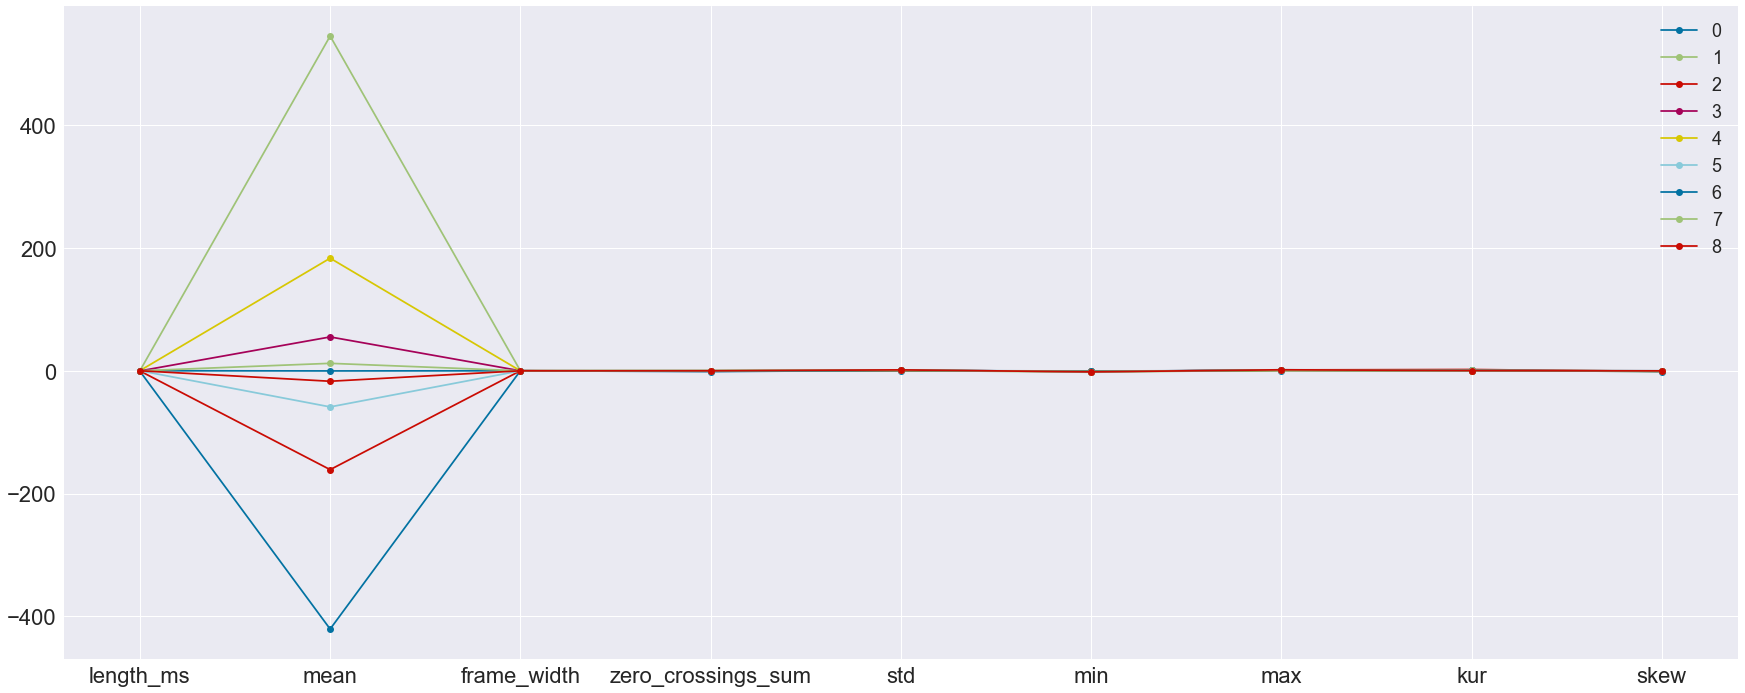

In [23]:
# Parallel plot per K-means con k=9 per audio originale

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(original_audio)), original_audio, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

Esperimento 2.1: original audio senza mean,frame_width

Test effettuato sulle features:
['length_ms', 'zero_crossings_sum', 'std', 'min', 'max', 'kur', 'skew']


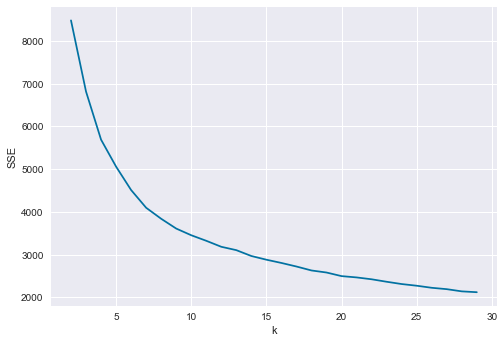

8


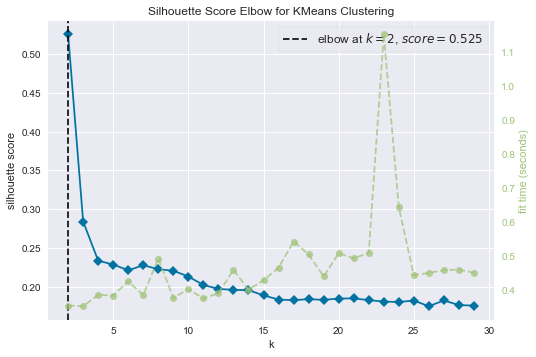

***************************************
k = 2| SSE = 8480.936067202332| silhouette = 0.5254525216896048
k = 3| SSE = 6816.643978244371| silhouette = 0.2841552741734555
k = 4| SSE = 5691.630281309523| silhouette = 0.23345725753323515
k = 5| SSE = 5060.153617895117| silhouette = 0.2285432523097426
k = 6| SSE = 4512.640635560218| silhouette = 0.22056630654357862
k = 7| SSE = 4098.04170911347| silhouette = 0.22774767563614037
k = 8| SSE = 3840.1215810669246| silhouette = 0.22272816160631165
k = 9| SSE = 3611.216683605096| silhouette = 0.22109671689909127
k = 10| SSE = 3454.9635227826648| silhouette = 0.21203841781708158
k = 11| SSE = 3325.0193055598697| silhouette = 0.2051553715116205
k = 12| SSE = 3184.7917562542852| silhouette = 0.19408267459075657
k = 13| SSE = 3106.097152229833| silhouette = 0.18127656308038065
k = 14| SSE = 2969.0471599721955| silhouette = 0.183854876962498
k = 15| SSE = 2882.6102043159653| silhouette = 0.18312726088565778
k = 16| SSE = 2806.4858575227827| silhouette 

In [24]:
# Exp. original_audio tranne media,frame_witdh ---> k=8 migliore

sse, silhouette, kl = res_K(df, original_audio2)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [56]:
# Come si evince dai dati il K-means con questo sottoinsieme è buono in termini di tradeoff(SSE,Silhouette) e realizza anche un buon clustering
#RISULTATO SODDISFACENTE per k=[8-11] con k=8(SSE=3840,Silhouette=0.22) che realizza il miglior cluster in termini di well-separatedly
# Anche k=9 potrebbe essere una buona scelta
X11=continuos_df[original_audio2]
scaler = RobustScaler() 
scaler.fit(X11)
X11_scal = scaler.transform(X11)

kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10, max_iter=100)
kmeans.fit(X11_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([274, 198,  94, 502, 402, 100, 449, 398], dtype=int64))

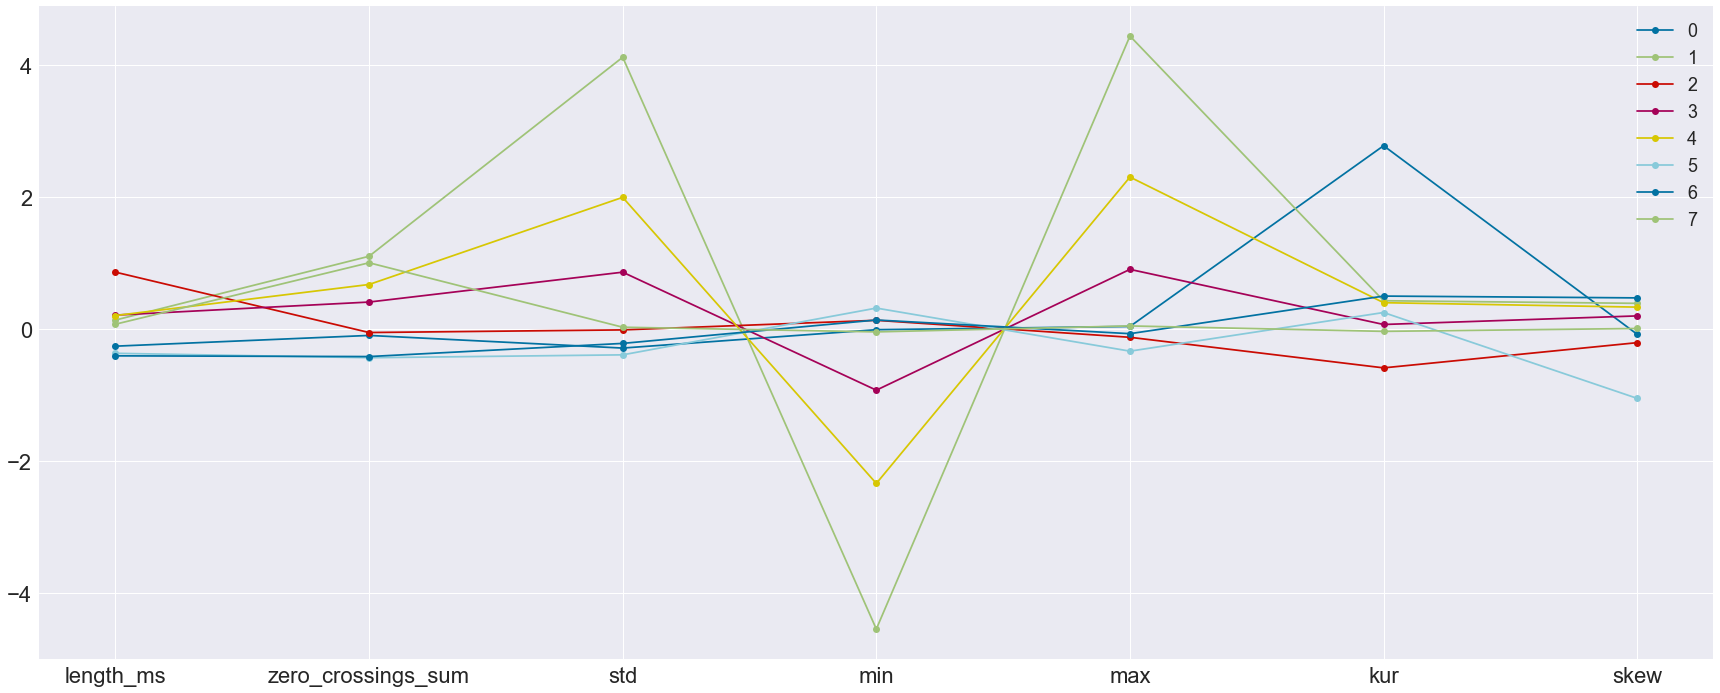

In [26]:
# Parallel plot per K-means con k=9 per audio originale tranne mean,frame_width

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(original_audio2)), original_audio2, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

In [27]:
X11=continuos_df[original_audio2]
scaler = RobustScaler() 
scaler.fit(X11)
X11_scal = scaler.transform(X11)

kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10, max_iter=100)
kmeans.fit(X11_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([241, 103, 237,  88, 364, 176, 418, 508, 282], dtype=int64))

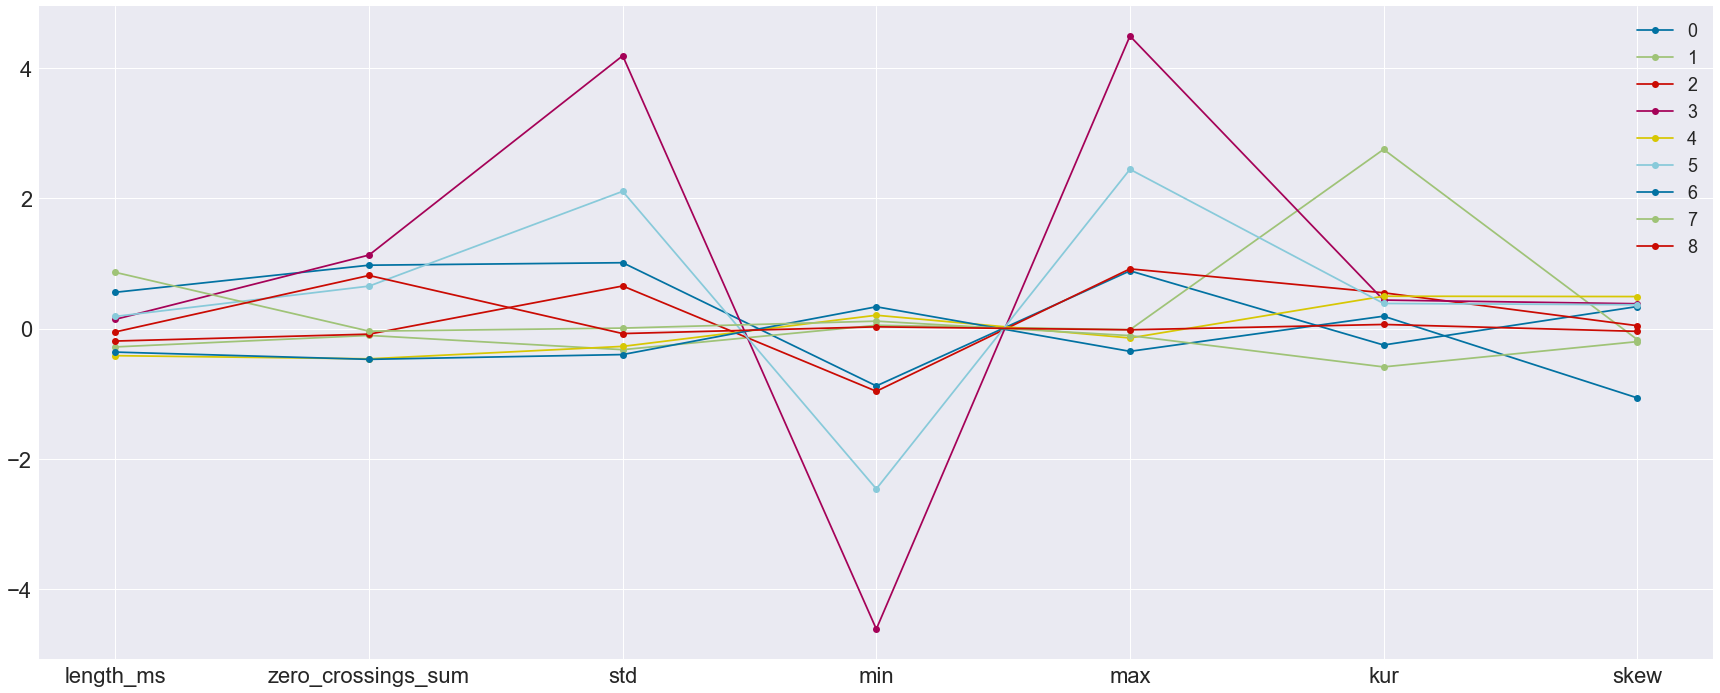

In [28]:
# Parallel plot per K-means con k=9 per audio originale tranne mean,frame_width

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(original_audio2)), original_audio2, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

In [29]:
X11=continuos_df[original_audio2]
scaler = RobustScaler() 
scaler.fit(X11)
X11_scal = scaler.transform(X11)

kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(X11_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([218, 348, 104, 472, 155,  94,  75, 405, 269, 277], dtype=int64))

In [30]:
X11=continuos_df[original_audio2]
scaler = RobustScaler() 
scaler.fit(X11)
X11_scal = scaler.transform(X11)

kmeans = KMeans(init='k-means++', n_clusters=11, n_init=10, max_iter=100)
kmeans.fit(X11_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([348, 279,  75,  91, 271, 323, 223, 194, 391,  93, 129], dtype=int64))

In [31]:
# CROSS TAB EMOZIONI-CLUSTER ORIGINAL AUDIO2

emotion_audio2cluster = pd.crosstab(df['emotion'], kmeans.labels_)
emotion_audio2cluster

col_0,0,1,2,3,4,5,6,7,8,9,10
emotion,,,,,,,,,,,
angry,16,32,65,14,30,2,51,46,10,49,53
calm,52,57,0,8,24,117,0,7,102,0,1
disgust,39,1,0,27,64,2,6,16,35,0,2
fearful,40,35,8,3,37,36,56,50,45,31,31
happy,51,76,2,7,23,20,59,46,38,13,34
neutral,46,25,0,6,11,55,1,4,38,0,0
sad,42,53,0,22,47,89,18,19,75,0,7
surprised,62,0,0,4,35,2,32,6,48,0,1


Esperimento 3: mfcc audio

Test effettuato sulle features:
['mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max']


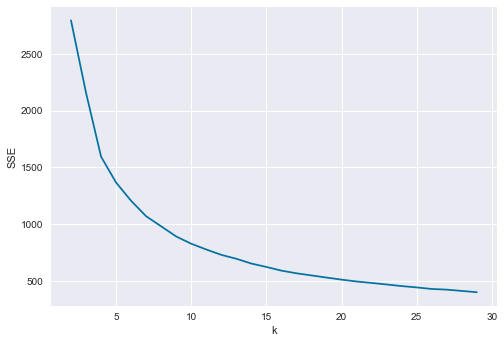

9


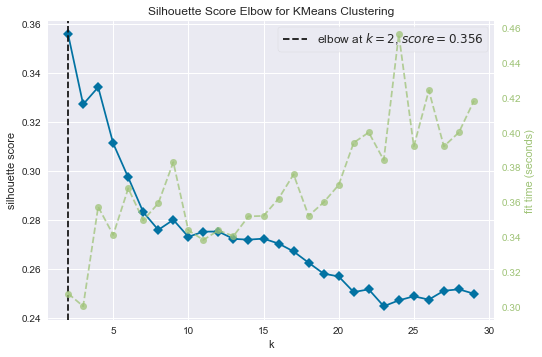

***************************************
k = 2| SSE = 2795.0504975603044| silhouette = 0.3557524760569745
k = 3| SSE = 2156.868101712178| silhouette = 0.3273369909626739
k = 4| SSE = 1593.887380848879| silhouette = 0.33409671532639584
k = 5| SSE = 1365.234549224365| silhouette = 0.31136931416661306
k = 6| SSE = 1204.2478270984138| silhouette = 0.2962111336552202
k = 7| SSE = 1067.9439461818154| silhouette = 0.2837934300626686
k = 8| SSE = 979.1220576025354| silhouette = 0.27405430568426514
k = 9| SSE = 889.5657449003162| silhouette = 0.2794958188144295
k = 10| SSE = 825.9145370842087| silhouette = 0.2730062347469866
k = 11| SSE = 774.9604470727689| silhouette = 0.273203723356289
k = 12| SSE = 727.5992283470946| silhouette = 0.2742312617477416
k = 13| SSE = 693.1631584693926| silhouette = 0.2706179644678824
k = 14| SSE = 650.9472594568875| silhouette = 0.2758678902445207
k = 15| SSE = 621.0207323468869| silhouette = 0.2754824255266929
k = 16| SSE = 588.5688269284244| silhouette = 0.27084

In [32]:
# Exp. mfcc_audio---> k=9

sse, silhouette, kl = res_K(df,mfcc_audio)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [33]:
# Come si evince dai dati il K-means con questo sottoinsieme è buono in termini di tradeoff(SSE,Silhouette)ed è buono in termini di well-separatedly
#  Ad ora l'mfcc a parità di K=9(SSE= 889,SILHOUETTE=0.279) con gli esperimenti precedente realizza un miglior clustering e un miglior tradeoff
# Anche se per questo subset il miglior k in generale sarebbe k=13 (SSE=690,SILHOUETTE=0.267)
X3=continuos_df[mfcc_audio]
scaler = RobustScaler() 
scaler.fit(X3)
X3_scal = scaler.transform(X3)

kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10, max_iter=100)
kmeans.fit(X3_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([291, 223, 261, 203, 385, 281, 362, 143, 268], dtype=int64))

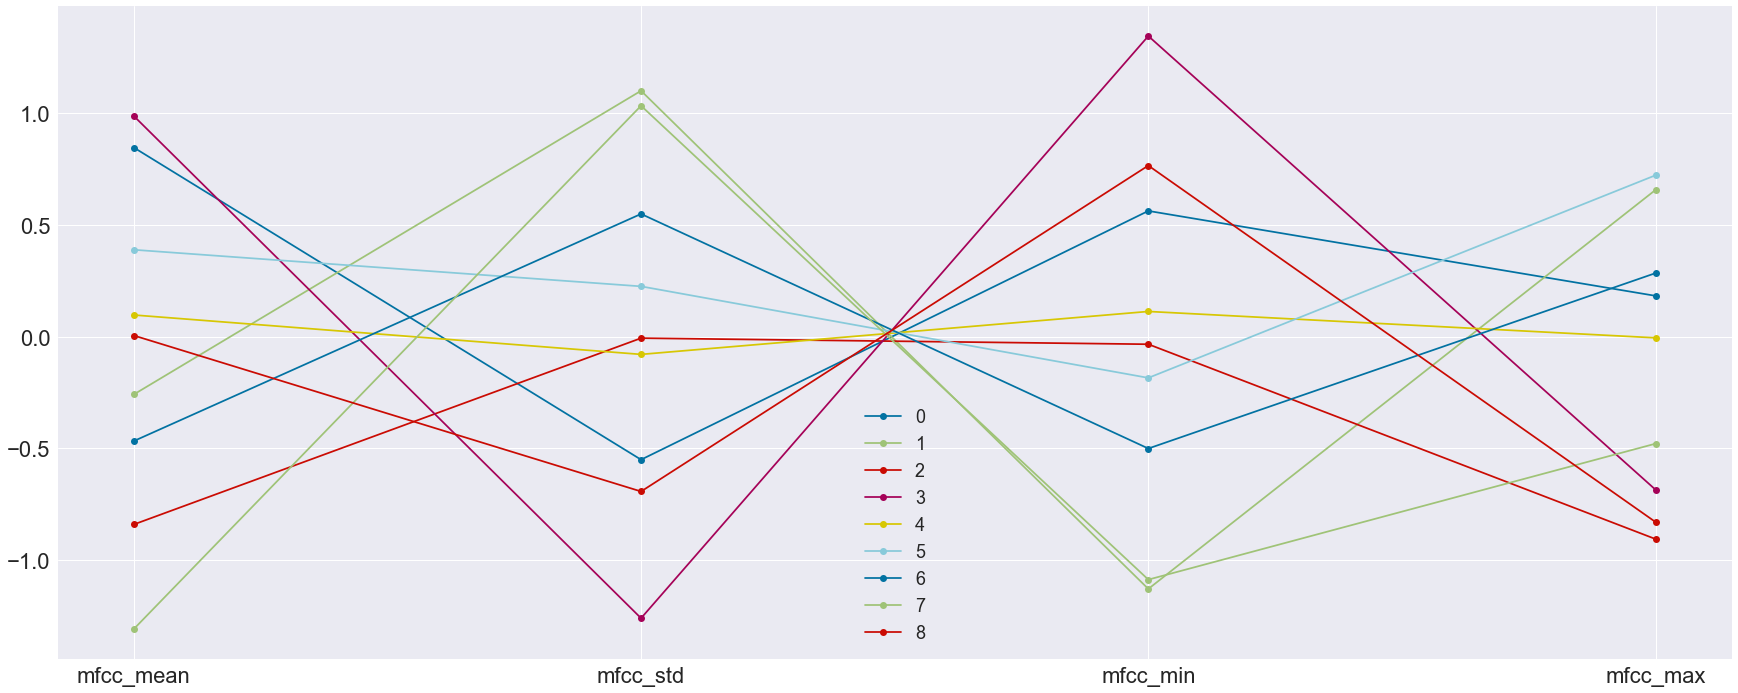

In [34]:
# Parallel plot per K-means con k=9 per audio originale

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(mfcc_audio)), mfcc_audio, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

In [35]:
X3=continuos_df[mfcc_audio]
scaler = RobustScaler() 
scaler.fit(X3)
X3_scal = scaler.transform(X3)

kmeans = KMeans(init='k-means++', n_clusters=12, n_init=10, max_iter=100)
kmeans.fit(X3_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 94, 153, 327, 268, 172, 117, 257, 270, 163,  94, 297, 205],
       dtype=int64))

In [36]:
X3=continuos_df[mfcc_audio]
scaler = RobustScaler() 
scaler.fit(X3)
X3_scal = scaler.transform(X3)

kmeans = KMeans(init='k-means++', n_clusters=12, n_init=10, max_iter=100)
kmeans.fit(X3_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([171, 330, 324, 203, 147, 140, 131, 196,  74, 188, 268, 245],
       dtype=int64))

In [37]:
emotion_mfcccluster = pd.crosstab(df['emotion'], kmeans.labels_)
emotion_mfcccluster

col_0,0,1,2,3,4,5,6,7,8,9,10,11
emotion,,,,,,,,,,,,
angry,2,38,9,5,64,11,83,31,0,2,74,49
calm,65,43,42,64,1,34,0,4,43,53,10,9
disgust,17,39,49,4,1,16,1,24,1,13,13,14
fearful,6,53,35,19,50,8,20,35,8,12,58,68
happy,6,48,45,20,27,24,17,39,0,16,66,61
neutral,24,20,41,32,0,18,0,7,7,28,5,4
sad,41,46,64,54,2,18,7,23,15,44,30,28
surprised,10,43,39,5,2,11,3,33,0,20,12,12


Esperimento 4: sc audio 

Test effettuato sulle features:
['sc_mean', 'sc_std', 'sc_min', 'sc_max', 'sc_kur', 'sc_skew']


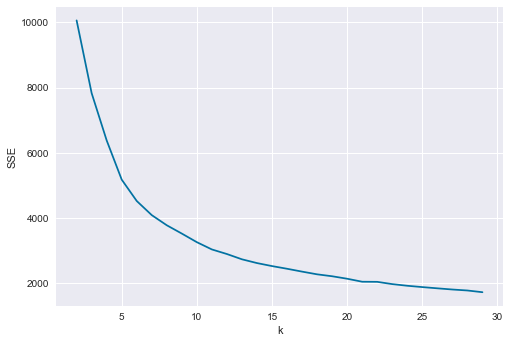

8


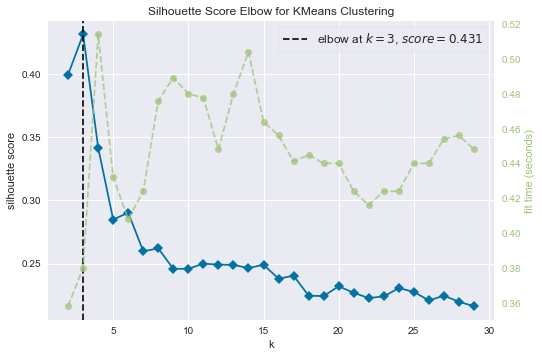

***************************************
k = 2| SSE = 10057.978756097193| silhouette = 0.3996904246532464
k = 3| SSE = 7827.332720129668| silhouette = 0.4314905215685049
k = 4| SSE = 6378.032697299342| silhouette = 0.31973969654316187
k = 5| SSE = 5176.2120253445555| silhouette = 0.2849251139738904
k = 6| SSE = 4521.084166042052| silhouette = 0.28991688648805397
k = 7| SSE = 4087.5627613753213| silhouette = 0.25977203989786096
k = 8| SSE = 3776.4767385471714| silhouette = 0.2626220848188114
k = 9| SSE = 3521.6676297785934| silhouette = 0.24402430786413987
k = 10| SSE = 3258.1278508780997| silhouette = 0.2441040293435142
k = 11| SSE = 3035.2840220322287| silhouette = 0.24730797162889376
k = 12| SSE = 2894.963034599766| silhouette = 0.24183574759429116
k = 13| SSE = 2733.038666961865| silhouette = 0.2486931131611659
k = 14| SSE = 2617.5387935583985| silhouette = 0.24389768169114484
k = 15| SSE = 2525.2966665655085| silhouette = 0.22907838141915826
k = 16| SSE = 2443.406366621234| silhouet

In [38]:
# Exp. sc_audio---> k=[8,12]

sse, silhouette, kl = res_K(df,sc_audio)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [39]:
# Come si evince dai dati il K-means con questo sottoinsieme è buono in termini di tradeoff(SSE,Silhouette) 
# K=8 miglior valore
X4=continuos_df[sc_audio]
scaler = RobustScaler() 
scaler.fit(X4)
X4_scal = scaler.transform(X4)

kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10, max_iter=100)
kmeans.fit(X4_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([561,  57, 766, 183,  37, 128, 322, 363], dtype=int64))

In [40]:
X4=continuos_df[sc_audio]
scaler = RobustScaler() 
scaler.fit(X4)
X4_scal = scaler.transform(X4)

kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10, max_iter=100)
kmeans.fit(X4_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([311, 287, 179, 557,  37,  56, 426, 128, 436], dtype=int64))

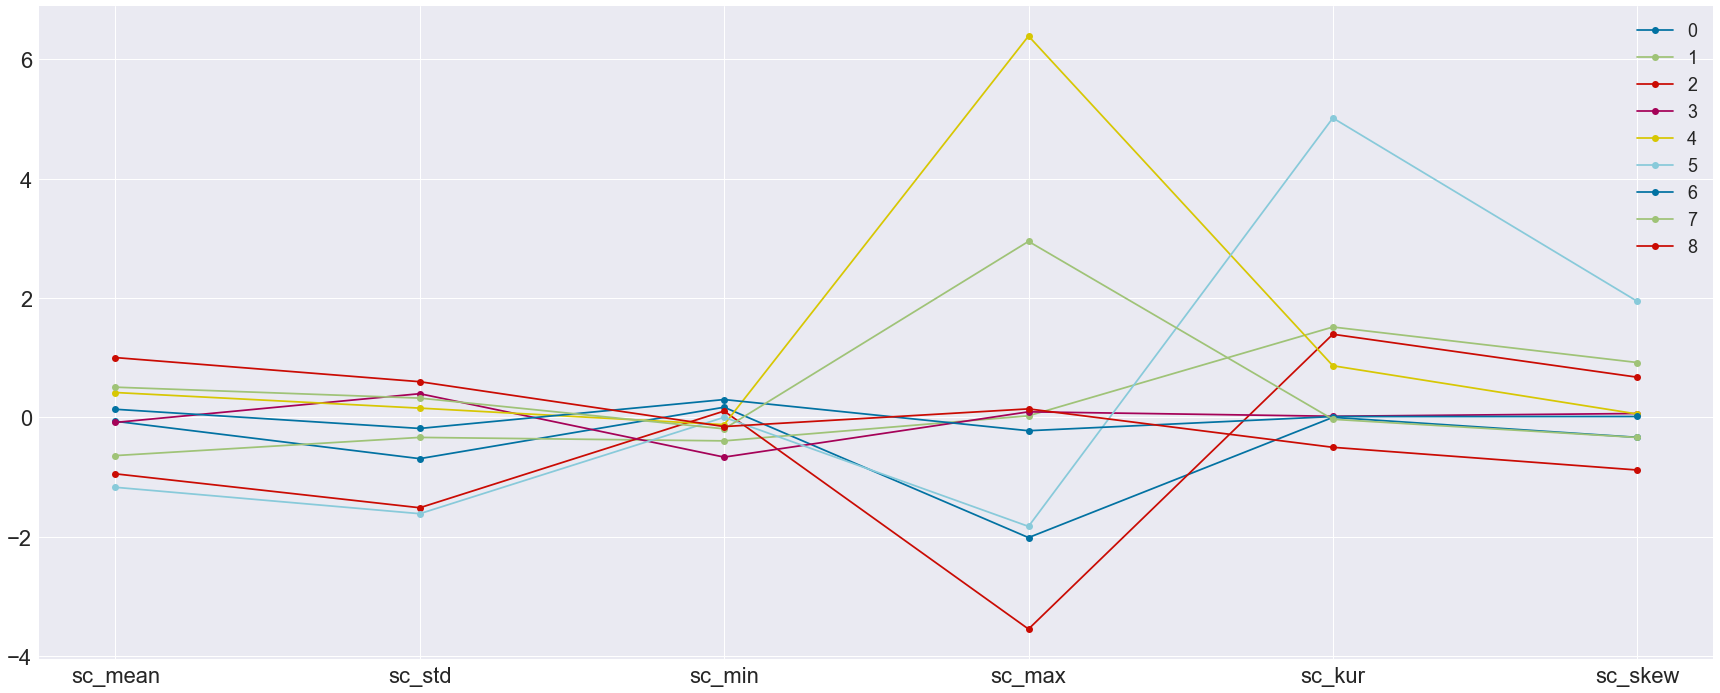

In [41]:
# Parallel plot per K-means con k=9 per audio originale

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(sc_audio)), sc_audio, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

In [42]:
X4=continuos_df[sc_audio]
scaler = RobustScaler() 
scaler.fit(X4)
X4_scal = scaler.transform(X4)

kmeans = KMeans(init='k-means++', n_clusters=11, n_init=10, max_iter=100)
kmeans.fit(X4_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([127, 286, 372,  88, 372,  36,  35, 148, 491, 396,  66], dtype=int64))

In [43]:
X4=continuos_df[sc_audio]
scaler = RobustScaler() 
scaler.fit(X4)
X4_scal = scaler.transform(X4)

kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(X4_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([821, 793, 192, 125, 378, 108], dtype=int64))

In [44]:
X4=continuos_df[sc_audio]
scaler = RobustScaler() 
scaler.fit(X4)
X4_scal = scaler.transform(X4)

kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(X4_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([874, 406, 128, 855, 154], dtype=int64))

In [45]:
X4=continuos_df[sc_audio]
scaler = RobustScaler() 
scaler.fit(X4)
X4_scal = scaler.transform(X4)

kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10, max_iter=100)
kmeans.fit(X4_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([1296,  383,  132,  606], dtype=int64))

In [46]:
emotion_sccluster = pd.crosstab(df['emotion'], kmeans.labels_)
emotion_sccluster

col_0,0,1,2,3
emotion,,,,
angry,149,80,20,119
calm,187,51,26,104
disgust,124,29,20,19
fearful,160,82,9,121
happy,185,61,21,102
neutral,132,17,11,26
sad,215,47,10,100
surprised,144,16,15,15


esperimento 5: stft audio

Test effettuato sulle features:
['stft_mean', 'stft_std', 'stft_min', 'stft_kur', 'stft_skew']


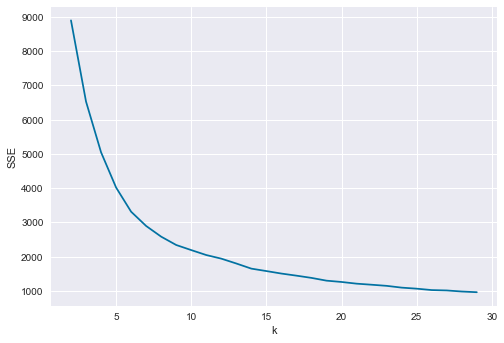

8


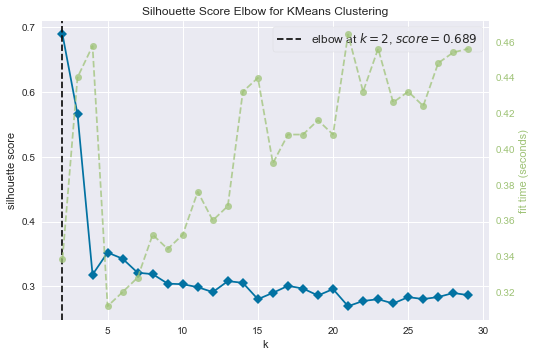

***************************************
k = 2| SSE = 8900.399737437823| silhouette = 0.6892570142151159
k = 3| SSE = 6531.111980636098| silhouette = 0.565761474128148
k = 4| SSE = 5049.834193888639| silhouette = 0.3180730754010124
k = 5| SSE = 4021.196991442145| silhouette = 0.34737397832015865
k = 6| SSE = 3314.4892417089636| silhouette = 0.34224218728747835
k = 7| SSE = 2897.8980662803833| silhouette = 0.3205568414612616
k = 8| SSE = 2585.9049893951155| silhouette = 0.31906674207138813
k = 9| SSE = 2342.624979685538| silhouette = 0.30388616204811686
k = 10| SSE = 2194.0525743366816| silhouette = 0.2964508879754192
k = 11| SSE = 2049.319964791879| silhouette = 0.29903400911657185
k = 12| SSE = 1943.9855656828531| silhouette = 0.29333775579293125
k = 13| SSE = 1802.1249612027912| silhouette = 0.2899448262912071
k = 14| SSE = 1652.3876120651867| silhouette = 0.29593528867466823
k = 15| SSE = 1581.2735184743012| silhouette = 0.28051929929973773
k = 16| SSE = 1508.5864272158456| silhouett

In [47]:
# Exp. stft_audio---> 

sse, silhouette, kl = res_K(df,stft_audio)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [48]:
# in definitiva k=9 restituisce il miglior compromesso tra tradeoff e well-separatedly


X5=continuos_df[stft_audio]
scaler = RobustScaler() 
scaler.fit(X5)
X5_scal = scaler.transform(X5)
kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10, max_iter=100)
kmeans.fit(X5_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([560,  74, 178, 142, 586,  33, 465, 135, 244], dtype=int64))

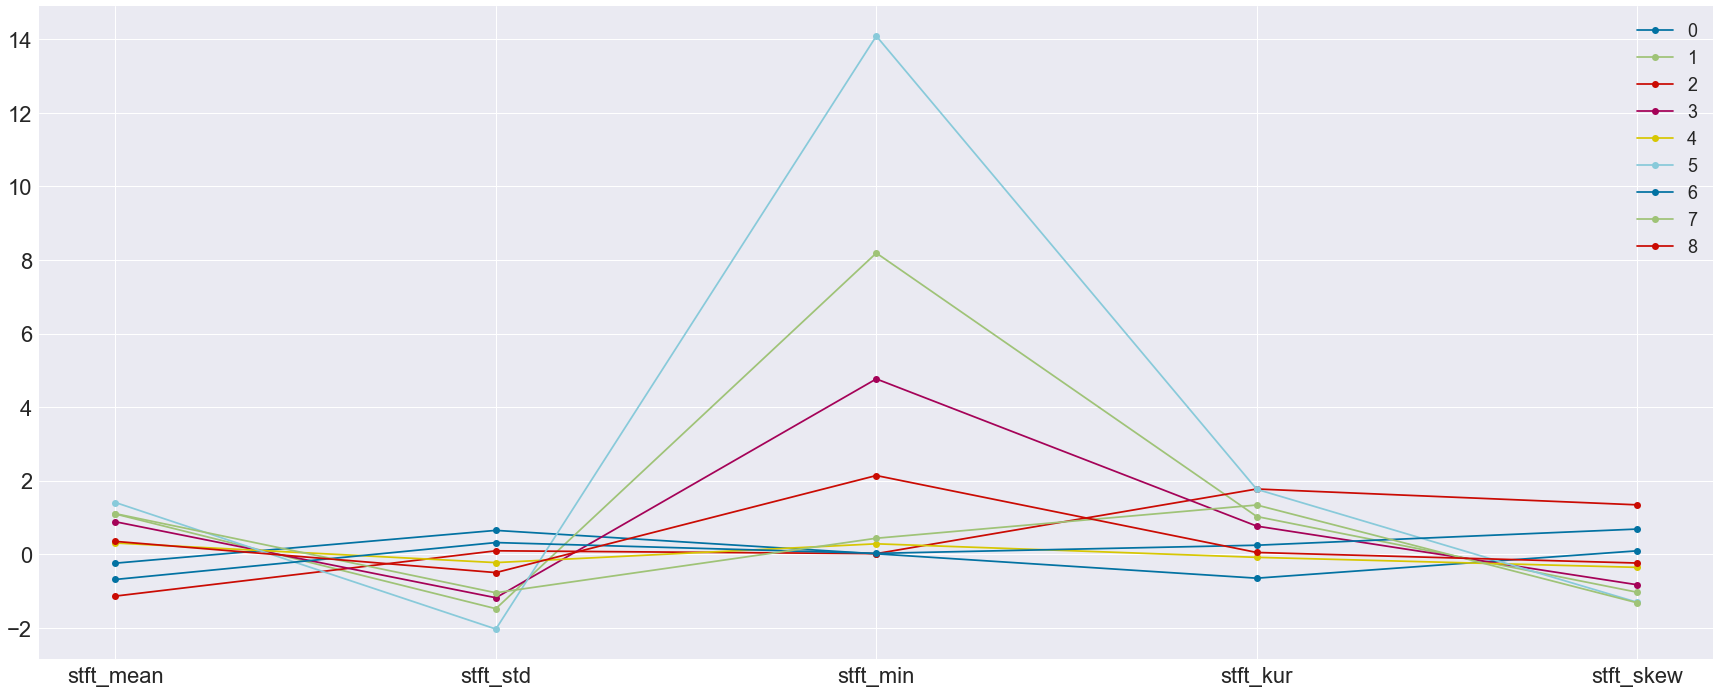

In [49]:
# Parallel plot per K-means con k=9 per audio originale

centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(stft_audio)), stft_audio, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

In [50]:
X5=continuos_df[stft_audio]
scaler = RobustScaler() 
scaler.fit(X5)
X5_scal = scaler.transform(X5)

kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(X5_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([557, 103, 546, 185, 131,  43,  23, 230, 133, 466], dtype=int64))

In [51]:
X5=continuos_df[stft_audio]
scaler = RobustScaler() 
scaler.fit(X5)
X5_scal = scaler.transform(X5)

kmeans = KMeans(init='k-means++', n_clusters=11, n_init=10, max_iter=100)
kmeans.fit(X5_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([211,  53, 381, 515, 128,  23, 286, 102, 110, 435, 173], dtype=int64))

In [52]:
X5=continuos_df[stft_audio]
scaler = RobustScaler() 
scaler.fit(X5)
X5_scal = scaler.transform(X5)

kmeans = KMeans(init='k-means++', n_clusters=12, n_init=10, max_iter=100)
kmeans.fit(X5_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([439,  51, 281,  23,  67, 153, 334, 551, 120, 101,  94, 203],
       dtype=int64))

In [53]:
X5=continuos_df[stft_audio]
scaler = RobustScaler() 
scaler.fit(X5)
X5_scal = scaler.transform(X5)

kmeans = KMeans(init='k-means++', n_clusters=13, n_init=10, max_iter=100)
kmeans.fit(X5_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([280,  51, 234,  94,  23, 442, 101,  68, 301,  66, 447, 112, 198],
       dtype=int64))

In [54]:
X5=continuos_df[stft_audio]
scaler = RobustScaler() 
scaler.fit(X5)
X5_scal = scaler.transform(X5)

kmeans = KMeans(init='k-means++', n_clusters=14, n_init=10, max_iter=100)
kmeans.fit(X5_scal)
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 97, 413,  43, 104, 209, 127, 357, 197,  22,  67,  95, 393,   7,
        286], dtype=int64))

In [55]:
emotion_stftcluster = pd.crosstab(df['emotion'], kmeans.labels_)
emotion_stftcluster

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
emotion,,,,,,,,,,,,,,
angry,31,54,1,5,25,15,60,50,2,8,9,48,0,60
calm,10,66,18,18,47,20,40,8,11,7,23,66,1,33
disgust,15,23,4,16,7,21,45,9,2,9,2,17,0,22
fearful,16,56,4,11,38,8,43,46,1,9,25,51,3,61
happy,8,70,1,13,38,7,50,38,0,6,15,67,0,56
neutral,5,38,7,16,15,4,23,16,2,8,6,37,1,8
sad,6,74,7,22,37,14,45,23,3,10,15,77,2,37
surprised,6,32,1,3,2,38,51,7,1,10,0,30,0,9
